In [1]:
# First import library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
# Import argparse for command-line options
import argparse
# Import os.path for file path manipulation
import os.path
import matplotlib.pyplot as plt

OV9282 sensor

image area : 3896 x 2453 µm

pixel size : 3.0 µm

# 1. depth example

In [132]:
pipeline = rs.pipeline()

#Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 360, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

Depth Scale is:  0.0010000000474974513


In [63]:
i = 0

max distance is : 64297 min is : 0


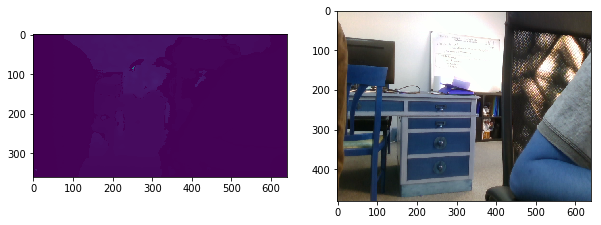

In [103]:
while True:
    # This call waits until a new coherent set of frames is available on a device
    # Calls to get_frame_data(...) and get_frame_timestamp(...) on a device will return stable values until wait_for_frames(...) is called
    frames = pipeline.wait_for_frames()
    depth = frames.get_depth_frame()
    color = frames.get_color_frame()
    if not depth: continue
    dd = np.asanyarray(depth.get_data())
    rr = np.asanyarray(color.get_data())
    print('max distance is :',dd.max(),'min is :', dd.min())
    #np.save('frames/rgb/'+str(i).zfill(3)+'.npy', rr)
    #np.save('frames/d/'+str(i).zfill(3)+'.npy', dd)
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(dd)
    plt.subplot(122);plt.imshow(rr)
    i = i + 1
    break

### 1.1 by get_distance()

In [36]:
depth.get_distance(100, 200)

0.36100003123283386

In [58]:
def get_depth(depth, bbx):
    #input depth is a frames.get_depth_frame()
    #bbx is x_min, y_min, x_max, y_max
    hh = bbx[2]-bbx[0]
    ww = bbx[3]-bbx[1]
    result = np.zeros((hh,ww))
    for i in range(hh):
        for j in range(ww):
            x = int(i+bbx[0])
            y = int(j+bbx[1])
            result[i,j] = depth.get_distance(y,x)
    return result

max distance is : 65.53500366210938 min is : 0.0


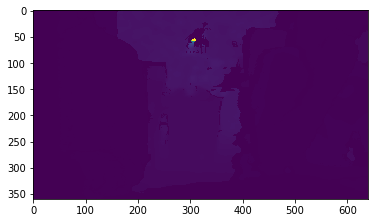

In [62]:
dd_part = get_depth(depth, [0,0,360,640])
plt.imshow(dd_part)
print('max distance is :',dd_part.max(),'; min is :', dd_part.min())

the difference between depth(color)*depth_scale and depth.get_distance()

In [65]:
error = 0
for x in range(360):
    for y in range(640):
        error += dd[x,y]*depth_scale - depth.get_distance(y,x)
print(error)

6.221968214958906e-05


As a result, the depth * depth_scale is the distance calculated by the realsense camera.

# Point cloud

In [96]:
pc = rs.pointcloud()
depth = frames.get_depth_frame()
color = frames.get_color_frame()
pc.map_to(color)
points = pc.calculate(depth)
points.export_to_ply("1.ply", color)

In [29]:
pts = np.asanyarray(points.get_data())

# read bag example

In [ ]:
# Create object for parsing command-line options
parser = argparse.ArgumentParser(description="Read recorded bag file and display depth stream in jet colormap.\
                                Remember to change the stream resolution, fps and format to match the recorded.")
# Add argument which takes path to a bag file as an input
parser.add_argument("-i", "--input", type=str, help="Path to the bag file")
# Parse the command line arguments to an object
args = parser.parse_args()
# Safety if no parameter have been given
if not args.input:
    print("No input paramater have been given.")
    print("For help type --help")
    exit()
# Check if the given file have bag extension

In [45]:
inp = 'C:/Users/lenovo/Documents/20180716_144453.bag'
# Create pipeline
pipeline = rs.pipeline()
# Create a config object
config = rs.config()
# Tell config that we will use a recorded device from filem to be used by the pipeline through playback.
rs.config.enable_device_from_file(config, inp)
# Configure the pipeline to stream the depth stream
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
#config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
# Start streaming from file
pipeline.start(config)

# Create opencv window to render image in
cv2.namedWindow("Depth Stream", cv2.WINDOW_AUTOSIZE)

# Streaming loop
i = 0
while True:
    # Get frameset of depth
    frames = pipeline.wait_for_frames()
    # Get depth frame
    depth_frame = frames.get_depth_frame()
    image_frame = frames.get_color_frame()
    # Colorize depth frame to jet colormap
    depth_color_frame = rs.colorizer().colorize(depth_frame)
    # Convert depth_frame to numpy array to render image in opencv
    depth_color_image = np.asanyarray(depth_color_frame.get_data())
    #color_image = np.asanyarray(image_frame.get_data())
    # Render image in opencv window
    cv2.imshow("Depth Stream", depth_color_image)
    #cv2.imshow("Depth Stream", color_image)
    key = cv2.waitKey(1)
    # if pressed escape exit program
    if i >= 27:
        cv2.destroyAllWindows()
        break
    i += 1

In [18]:
pipeline.get_active_profile()

# Align

In [137]:
i = 0

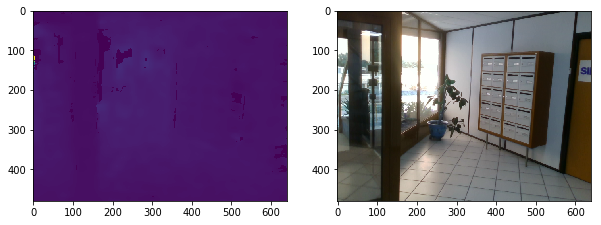

In [170]:
while True:
    # This call waits until a new coherent set of frames is available on a device
    # Calls to get_frame_data(...) and get_frame_timestamp(...) on a device will return stable values until wait_for_frames(...) is called
    frames = pipeline.wait_for_frames()
    align_to = rs.stream.color
    align = rs.align(align_to)
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(depth_image)
    plt.subplot(122);plt.imshow(color_image)
    np.save('frames/rgb/'+str(i).zfill(3)+'.npy', color_image)
    np.save('frames/d/'+str(i).zfill(3)+'.npy', depth_image)
    i = i + 1
    break